In [1]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
import soundfile as sf
import math

#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final_Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


## Decimation
Theory taken from Orfandis Introduction To Signal Processing

"Decimation by an integer factor L is the reverse of interpolation, that is, decreasing the sampling rate from the high rate fs' to the lower rate fs = fs'/L."

x_down(n) = x'(nL)

Will require some sort of anti aliasing as lowering the sample rate will result in some frequencies existing outside the new nyquist frequency, leading to aliasing

In [2]:
fs = fs #Original Fs
fs_new = 7000 #New Fs

L = fs/fs_new


b_3, a_3 = signal.butter(3, ((fs_new)/(2)), 'low', fs=fs)

dataL_filt = signal.lfilter(b_3, a_3, data[:,0])
dataR_filt = signal.lfilter(b_3, a_3, data[:,1])


output = np.zeros((len(data), 2))

for i in range(len(data)):
    if(i % int(L) == 0):
        output[i, 0] = dataL_filt[i]
        output[i, 1] = dataR_filt[i]
        #output[i, 0] = data[i, 0]
        #output[i, 1] = data[i, 1]



In [10]:
sd.play(output, fs)

## Upsampling then Downsampling
L/M

In [34]:
fs = fs
fs_new = 12000

L_factor = fs/fs_new #upsample factor

fs_high = fs*L_factor
M_factor = fs_high/fs_new #Decimation factor

N_factor= fs/fs_new

upsampled_output = np.zeros((len(data)*int(L_factor), 2))

#Upsampling
for i in range(len(data)):
    upsampled_output[(int(i * L_factor)-1),:] = data[i,:]


#Filtering
fc_min = 0.5 * min(fs, fs_new)
b_LM, a_LM = signal.butter(3, fc_min, 'low', fs=fs)

filtered_Upsampled = signal.lfilter(b_LM, a_LM, upsampled_output, axis = 0)

#Downsampling
downsampled_output = np.zeros((len(data), 2))
for i in range(len(downsampled_output)):
    if(int(i * M_factor) < len(filtered_Upsampled)):
        downsampled_output[int(i*N_factor), :] = filtered_Upsampled[int(i * M_factor), :]

In [35]:
sd.play(downsampled_output, fs)

In [42]:
sd.play(upsampled_output, fs)

In [6]:
sf.write("4kHz.wav", downsampled_output, fs)

## Using anti aliasing filter

## In the Frequency Domain

ccrma = https://ccrma.stanford.edu/~jos/JFB/JFB_4up.pdf

In [54]:
fs = fs
fs_new = 30000

N = fs/fs_new

data_fft = np.fft.fft(data)

Y = data_fft ** N

Y_down = np.zeros((len(Y), 2))

N2 = (fs*N)/fs_new
for m in range(len(Y)):
    Y_down[m, 0] = (1/N2) * ((Y[m,0] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))
    Y_down[m, 1] = (1/N2) * ((Y[m,1] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))

y_down = np.fft.ifft(Y_down).real

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_30154/1547079762.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_down[m, 0] = (1/N2) * ((Y[m,0] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_30154/1547079762.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_down[m, 1] = (1/N2) * ((Y[m,1] ** (1/N2)) * np.exp(-1j * m * (2*np.pi/N2)))


In [55]:
sd.play(y_down,(fs))

## Plots and Analysis

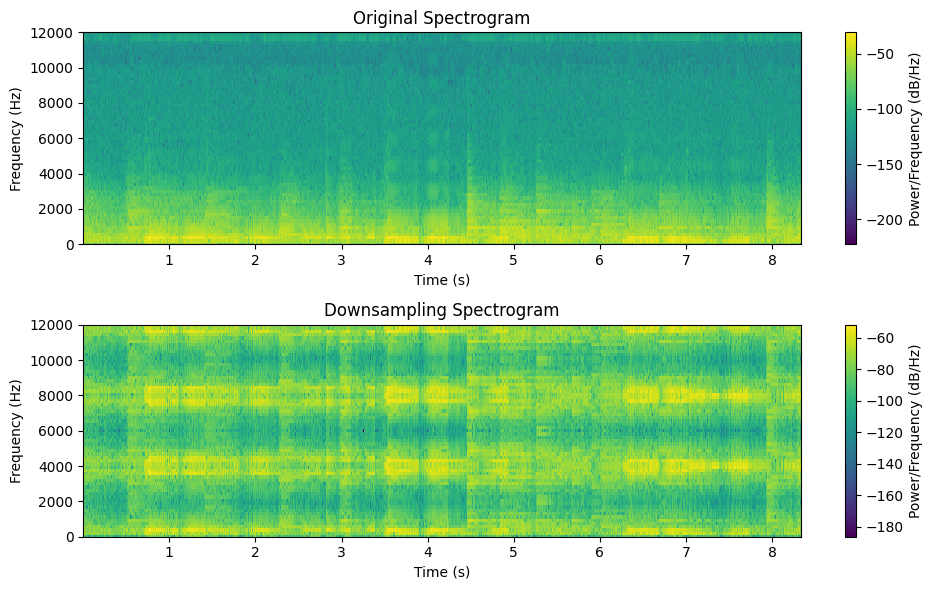

In [7]:
# Compute the spectrogram
frequencies_original, times_original, Sxx_original = signal.spectrogram(data[100000:500000,0], fs)

frequencies_dec, times_dec, Sxx_dec = signal.spectrogram(downsampled_output[100000:500000,0], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(times_original, frequencies_original, 10 * np.log10(Sxx_original), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Original Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.subplot(2, 1, 2)
plt.pcolormesh(times_dec, frequencies_dec, 10 * np.log10(Sxx_dec), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Downsampling Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0, 12000])

plt.tight_layout()
plt.show()